In [4]:
"""
ADOBE CONFIDENTIAL
Copyright 2024 Adobe
All Rights Reserved.
NOTICE: All information contained herein is, and remains
the property of Adobe and its suppliers, if any. The intellectual
and technical concepts contained herein are proprietary to Adobe 
and its suppliers and are protected by all applicable intellectual 
property laws, including trade secret and copyright laws. 
Dissemination of this information or reproduction of this material is 
strictly forbidden unless prior written permission is obtained from Adobe.
"""

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from lora_diffusion import patch_pipe
import torch
import torch.nn as nn
import os
import os.path as osp 
from transformers import CLIPTextModel, CLIPTokenizer
from training_scripts.continuous_word_mlp import continuous_word_mlp

model_id = "stabilityai/stable-diffusion-2-1"

# cur_model = "nonrigid-run" 
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
# patch_pipe(
#     pipe,
#     "ckpts/" + cur_model + "_sd.safetensors",
#     patch_text=True,
#     patch_ti=True,
#     patch_unet=True,
# )
patch_pipe(
    pipe,
    osp.join(f"ckpts/blue_truck/lora_weight_e299_s30000.safetensors"), 
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

continuous_word_model = continuous_word_mlp(input_size = 2, output_size = 1024)
continuous_word_model.load_state_dict(torch.load("ckpts/blue_truck/mlp299_s30000.pt"))
continuous_word_model.eval()

tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")




/home/test/anaconda3/envs/contwords/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
import math
cur_token = 'sks'

img_list = []

corresponding_emb = tokenizer(cur_token,
        padding="do_not_pad", \
         truncation=True, \
         max_length = tokenizer.model_max_length).input_ids[1]

interpolation_gap = 2
for idx in range(interpolation_gap):

    p = torch.Tensor([idx/(20 * math.pi)])
    # 15 the pre-defined number to normalize the attributes between 0 to 0.5
    x = torch.Tensor([torch.sin(2 * torch.pi * p), torch.cos(2 * torch.pi * p)]).cuda()
    continuous_word_model = continuous_word_model.cuda()
    mlp_emb = continuous_word_model(torch.unsqueeze(x, dim=0)).squeeze(0)
    
    """Replacing the rare token embeddings with the outputs of the MLP"""  
    with torch.no_grad():
        pipe.text_encoder.get_input_embeddings().weight[corresponding_emb] = mlp_emb

    torch.manual_seed(50)
    prompt = 'a sks photo of a bnha pickup truck in a garden'  
    # image = pipe(prompt, negative_prompt="bnha, worst quality", num_inference_steps=50, guidance_scale=6).images[0]
    image = pipe(prompt, negative_prompt="", num_inference_steps=50, guidance_scale=6).images[0]
    img_list.append(image)
    image.save(f"{idx}.jpg")
    


    

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:06<00:00,  7.63it/s]


In [7]:
for idx, image in enumerate(img_list):
    image.save(f"{idx}.jpg")

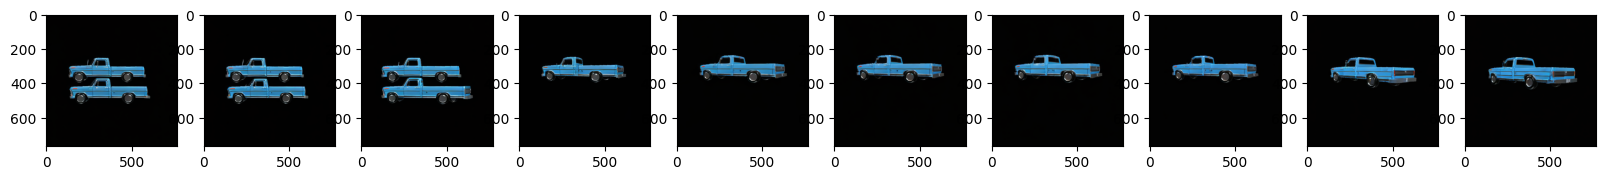

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(20, 5))
# img_list = img_list[:-1]
for i in range(len(img_list)):
    fig.add_subplot(1, len(img_list), i + 1)
    plt.imshow(np.array(img_list[i]))